# Modeling and Evaluation

## 1. Import Required Packages

In [1]:
import pandas as pd
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
pd.set_option("expand_frame_repr", True)
pd.set_option("max_colwidth", None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

## 2. Import Data

### 2.1 Imbalanced Datasets

In [2]:
X_train = np.load("data/Original/X_train.npy")
y_train = np.load("data/Original/y_train.npy")
X_val = np.load("data/Original/X_val.npy")
y_val = np.load("data/Original/y_val.npy")

In [3]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((208480, 68), (208480,), (52121, 68), (52121,))

### 2.2 Undersampled Datasets

In [4]:
X_train_under_sample = np.load("data/UnderSampling/X_train_undersample.npy")
y_train_under_sample = np.load("data/UnderSampling/y_train_undersample.npy")

### 2.3 Oversampled Datasets

In [5]:
X_train_over_sample = np.load("data/OverSampling/X_train_oversample.npy")
y_train_over_sample = np.load("data/OverSampling/y_train_oversample.npy")

### 2.4 SMOTE Datasets

In [6]:
X_train_smote = np.load("data/SMOTE/X_train_smote.npy")
y_train_smote = np.load("data/SMOTE/y_train_smote.npy")

In [7]:
datasets = [("Original", X_train, y_train), ("UnderSampling", X_train_under_sample, y_train_under_sample), ("OverSampling", X_train_over_sample, y_train_over_sample), ("SMOTE", X_train_smote, y_train_smote)]

### Helper Evaluation function to give all metrics after model Training

In [8]:
def evaluate_model(true, predicted, test=False):
    """
    Generate the confusion matrix and classification report
    """
    if test:
        cm = confusion_matrix(true, predicted)
        cr = classification_report(true, predicted)
        conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:1','Predicted:2','Predicted:3'],
                                             index=['Actual:1','Actual:2','Actual:3'])
        # confusion matrix in heatmap
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
        print(cr) 
    f1_micro = f1_score(true, predicted, average='micro')
    return f1_micro


# 3. Modeling with Decision Tree

### Helper for Tracking Experiment Results

In [9]:
import os
def write_results(results, file="results.csv"):
    # Path to the CSV file

    # Check if the file exists, if not create a new one with headers
    if not os.path.isfile(file):
        results.to_csv(file, header=True, index=False)
    else:
        # Append the results to the CSV file
        results.to_csv(file, mode='a', header=False, index=False)

### Helper For Training and Evalution of Decision Tree 

In [12]:
def train_and_evaluate_(X_train, y_train):    
    model_list = []
    model_parameters = []
    f1_micro_train = []
    f1_micro_val = []
    time_taken = []
    
    # start time
    start_time = time.time()

    # parameters you specify in the model (also add here too as you add in the model)
    model_parameters.append({'max_depth':model.get_params()['max_depth'],'min_samples_split':model.get_params()['min_samples_split'],
                             'class_weight':model.get_params()['class_weight']})

    model.fit(X_train, y_train)

    # end time
    end_time = time.time()

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Evaluate Train and Validation dataset
    model_train_f1 = evaluate_model(y_train, y_train_pred)
    model_val_f1 = evaluate_model(y_val, y_val_pred, test=True)

    model_list.append(model.__class__.__name__)

    print("Model Performance for Training Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_train_f1))
    print("--------------------------------------")

    print("Model Performance for Validation Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_val_f1))

    f1_micro_train.append(model_train_f1)
    f1_micro_val.append(model_val_f1)
    time_ellapsed = np.round(end_time - start_time, 2)
    time_taken.append(time_ellapsed)

    print('='*35)
    print('\n')

    results = pd.DataFrame(list(zip(model_list, f1_micro_train, f1_micro_val, time_taken, model_parameters)), 
                           columns=['Model Name', 'Train Micro-Averaged F1-Score', 'Val Micro-Averaged F1-Score', 'Time', 'Parameter']).sort_values(by=["Val Micro-Averaged F1-Score"],ascending=False)
    # write_results(results)
    return results

def model_evaluation_on_all_datasets():
    results_df = pd.DataFrame(columns=['Dataset', 'Model Name', 'Train Micro-Averaged F1-Score', 'Val Micro-Averaged F1-Score', 'Time', 'Parameter'])
    for dataset_name, X_train, y_train in datasets:
        print(f"Training on dataset: {dataset_name}")
        results = train_and_evaluate_(X_train, y_train)
        results['Dataset'] = dataset_name
        results_df = results_df.append(results, ignore_index=True)

    write_results(results_df, "decision_tree_results.csv")
    return results_df

### Initialize Decision Tree Model

In [13]:
model = DecisionTreeClassifier(max_depth=15, min_samples_split=30, random_state=42) # max_depth=15, min_samples_split=30

In [14]:
# a = tt

### Finally, Train And Evalute the Model on different Datasets :)

Training on dataset: Original


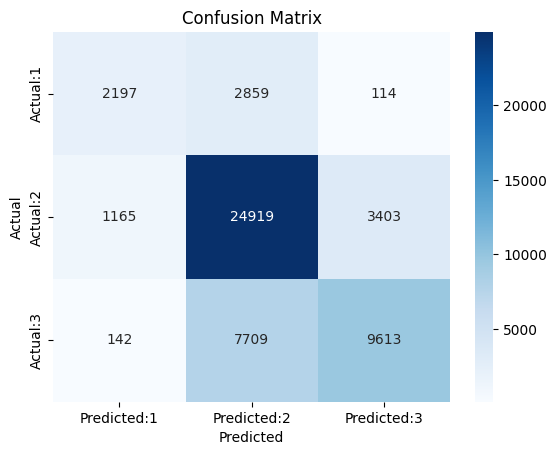

              precision    recall  f1-score   support

           0       0.63      0.42      0.51      5170
           1       0.70      0.85      0.77     29487
           2       0.73      0.55      0.63     17464

    accuracy                           0.70     52121
   macro avg       0.69      0.61      0.63     52121
weighted avg       0.70      0.70      0.69     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.7404
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.7047


Training on dataset: UnderSampling


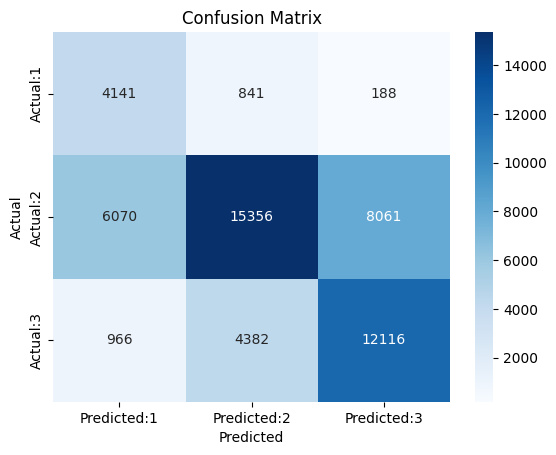

              precision    recall  f1-score   support

           0       0.37      0.80      0.51      5170
           1       0.75      0.52      0.61     29487
           2       0.59      0.69      0.64     17464

    accuracy                           0.61     52121
   macro avg       0.57      0.67      0.59     52121
weighted avg       0.66      0.61      0.61     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.7416
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6065


Training on dataset: OverSampling


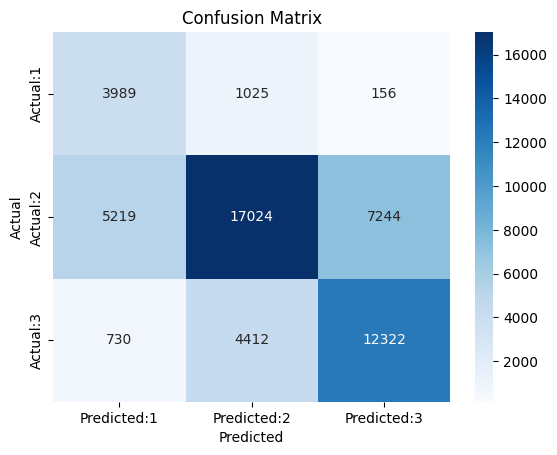

              precision    recall  f1-score   support

           0       0.40      0.77      0.53      5170
           1       0.76      0.58      0.66     29487
           2       0.62      0.71      0.66     17464

    accuracy                           0.64     52121
   macro avg       0.59      0.68      0.62     52121
weighted avg       0.68      0.64      0.65     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.7482
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6396


Training on dataset: SMOTE


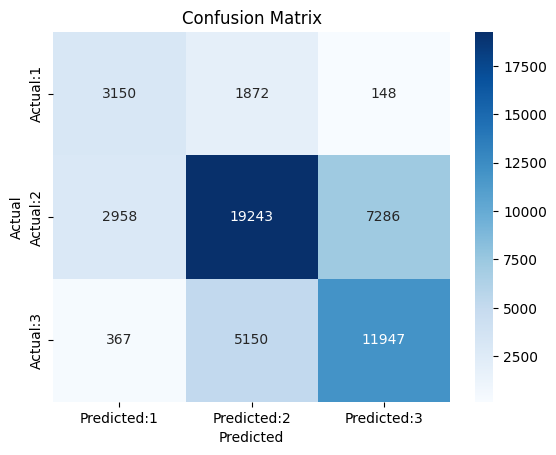

              precision    recall  f1-score   support

           0       0.49      0.61      0.54      5170
           1       0.73      0.65      0.69     29487
           2       0.62      0.68      0.65     17464

    accuracy                           0.66     52121
   macro avg       0.61      0.65      0.63     52121
weighted avg       0.67      0.66      0.66     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.7657
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6589




,Dataset,Model Name,Train Micro-Averaged F1-Score,Val Micro-Averaged F1-Score,Time,Parameter
0,Original,DecisionTreeClassifier,0.740397,0.704687,2.96,"{'max_depth': 15, 'min_samples_split': 30, 'class_weight': None}"
1,UnderSampling,DecisionTreeClassifier,0.741606,0.606531,0.69,"{'max_depth': 15, 'min_samples_split': 30, 'class_weight': None}"
2,OverSampling,DecisionTreeClassifier,0.748209,0.639569,5.27,"{'max_depth': 15, 'min_samples_split': 30, 'class_weight': None}"
3,SMOTE,DecisionTreeClassifier,0.765694,0.658852,6.06,"{'max_depth': 15, 'min_samples_split': 30, 'class_weight': None}"


In [15]:
model_evaluation_on_all_datasets()

**We see that the model performance is better on Original Dataset, whereas with others there is overfitting!**

## 3.1 Let's perform Hyperparameter Tuning on our DecisionTreeClassifier

### A. Using Grid Search CV 

In [18]:
def train_and_evaluate_with_tuning(X_train, y_train):
    # Create the hyperparameter grid
    param_grid = {
        "max_depth": [5, 10, 15, 20, 30],
        "min_samples_split": [10, 20, 30, 40, 50],
    }

    # Create the grid search object
    grid_search = GridSearchCV(
        DecisionTreeClassifier(random_state=42), param_grid, cv=5
    )

    # start time
    start_time = time.time()
    
    # Fit the grid search object to the training data
    grid_search.fit(X_train, y_train)
    
    # end time
    end_time = time.time()
    
    time_ellapsed = np.round(end_time - start_time, 2)
    
    # Print the best parameters
    print("Best parameters:", grid_search.best_params_)

    # Evaluate the best model on the validation data
    y_val_pred = grid_search.best_estimator_.predict(X_val)
    
    y_train_pred = grid_search.best_estimator_.predict(X_train)

    # Evaluate Train and Validation dataset
    model_train_f1 = evaluate_model(y_train, y_train_pred)
    model_val_f1 = evaluate_model(y_val, y_val_pred, test=True)

    print("Model Performance for Training Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_train_f1))
    print("--------------------------------------")

    print("Model Performance for Validation Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_val_f1))
    
    results = pd.DataFrame([["DecisionTreeClassifier", model_train_f1, model_val_f1, time_ellapsed, grid_search.best_params_]], columns=['Model Name', 'Train Micro-Averaged F1-Score', 'Val Micro-Averaged F1-Score', 'Time', 'Parameter']).sort_values(by=["Val Micro-Averaged F1-Score"],ascending=False)
    
    write_results(results)

    return results

### Evaluation Result on different Datasets

Best parameters: {'max_depth': 20, 'min_samples_split': 50}


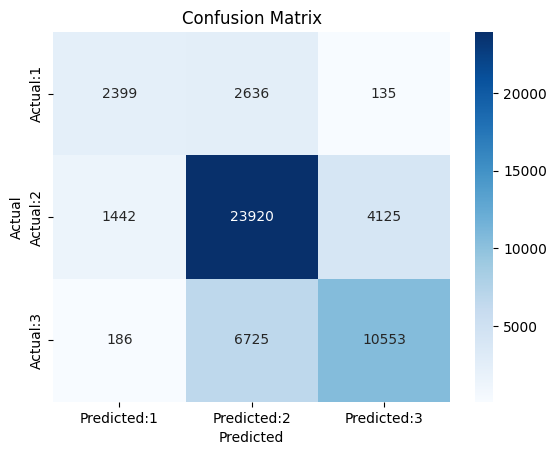

              precision    recall  f1-score   support

           0       0.60      0.46      0.52      5170
           1       0.72      0.81      0.76     29487
           2       0.71      0.60      0.65     17464

    accuracy                           0.71     52121
   macro avg       0.68      0.63      0.65     52121
weighted avg       0.70      0.71      0.70     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.7623
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.7074


,Model Name,Train Micro-Averaged F1-Score,Val Micro-Averaged F1-Score,Time,Parameter
0,DecisionTreeClassifier,0.762347,0.707431,321.31,"{'max_depth': 20, 'min_samples_split': 50}"


In [19]:
train_and_evaluate_with_tuning(X_train, y_train)

In [ ]:
train_and_evaluate_with_tuning(X_train_under_sample, y_train_under_sample)

In [ ]:
train_and_evaluate_with_tuning(X_train_over_sample, y_train_over_sample)

Best parameters: {'max_depth': 30, 'min_samples_split': 30}


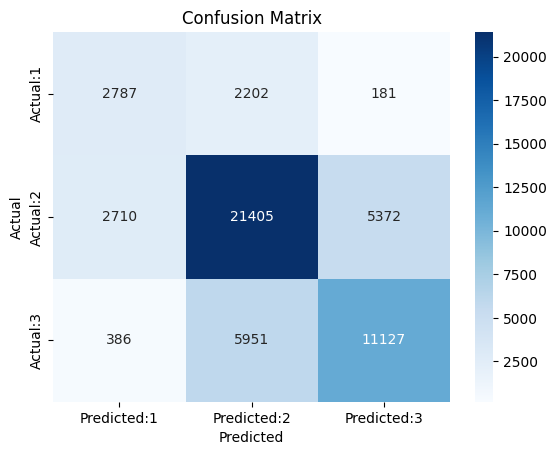

              precision    recall  f1-score   support

           0       0.47      0.54      0.50      5170
           1       0.72      0.73      0.73     29487
           2       0.67      0.64      0.65     17464

    accuracy                           0.68     52121
   macro avg       0.62      0.63      0.63     52121
weighted avg       0.68      0.68      0.68     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.8470
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6776


,Model Name,Train Micro-Averaged F1-Score,Val Micro-Averaged F1-Score,Time,Parameter
0,DecisionTreeClassifier,0.847037,0.677635,673.5,"{'max_depth': 30, 'min_samples_split': 30}"


In [20]:
train_and_evaluate_with_tuning(X_train_smote, y_train_smote)

**We see that the model is performing well on Training dataset but remains constant on validation data as previous, thus increasing overfitting!**


### B. With Randomized Search CV

In [21]:
def train_and_evaluate_with_rs_tuning(X_train, y_train):
    
    # Create the hyperparameter space
    param_space = {
        "max_depth": np.arange(5, 31),
        "min_samples_split": np.arange(10, 51),
        "class_weight": ["balanced", None],
    }

    # Create the random search object
    random_search = RandomizedSearchCV(
        DecisionTreeClassifier(random_state=42), param_space, cv=5
    )

    # start time
    start_time = time.time()
    
    # Fit the random search object to the training data
    random_search.fit(X_train, y_train)
    
    # end time
    end_time = time.time()
    
    time_ellapsed = np.round(end_time - start_time, 2)
    
    # Print the best parameters
    print("Best parameters:", random_search.best_params_)

    # Evaluate the best model on the validation data
    y_val_pred = random_search.best_estimator_.predict(X_val)
    
    y_train_pred = random_search.best_estimator_.predict(X_train)

    # Evaluate Train and Validation dataset
    model_train_f1 = evaluate_model(y_train, y_train_pred)
    model_val_f1 = evaluate_model(y_val, y_val_pred, test=True)

    print("Model Performance for Training Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_train_f1))
    print("--------------------------------------")

    print("Model Performance for Validation Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_val_f1))
    
    results = pd.DataFrame([["DecisionTreeClassifier", model_train_f1, model_val_f1, time_ellapsed, random_search.best_params_]], columns=['Model Name', 'Train Micro Averaged F1-Score', 'Val Micro Averaged F1-Score', 'Time', 'Parameter']).sort_values(by=["Val Micro Averaged F1-Score"],ascending=False)

    return results

Best parameters: {'min_samples_split': 47, 'max_depth': 26, 'class_weight': None}


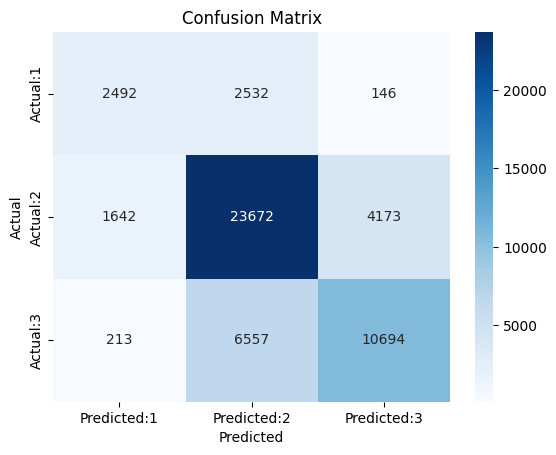

              precision    recall  f1-score   support

           0       0.57      0.48      0.52      5170
           1       0.72      0.80      0.76     29487
           2       0.71      0.61      0.66     17464

    accuracy                           0.71     52121
   macro avg       0.67      0.63      0.65     52121
weighted avg       0.70      0.71      0.70     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.7787
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.7072


,Model Name,Train Micro Averaged F1-Score,Val Micro Averaged F1-Score,Time,Parameter
0,DecisionTreeClassifier,0.778737,0.707162,132.98,"{'min_samples_split': 47, 'max_depth': 26, 'class_weight': None}"


In [22]:
train_and_evaluate_with_rs_tuning(X_train, y_train)

In [ ]:
train_and_evaluate_with_rs_tuning(X_train_under_sample, y_train_under_sample)

In [ ]:
train_and_evaluate_with_rs_tuning(X_train_over_sample, y_train_over_sample)

Best parameters: {'min_samples_split': 29, 'max_depth': 29, 'class_weight': 'balanced'}


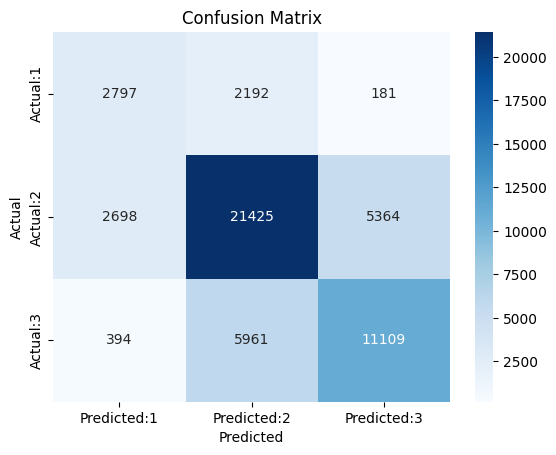

              precision    recall  f1-score   support

           0       0.47      0.54      0.51      5170
           1       0.72      0.73      0.73     29487
           2       0.67      0.64      0.65     17464

    accuracy                           0.68     52121
   macro avg       0.62      0.63      0.63     52121
weighted avg       0.68      0.68      0.68     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.8470
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6779


,Model Name,Train Micro Averaged F1-Score,Val Micro Averaged F1-Score,Time,Parameter
0,DecisionTreeClassifier,0.846962,0.677865,310.31,"{'min_samples_split': 29, 'max_depth': 29, 'class_weight': 'balanced'}"


In [23]:
train_and_evaluate_with_rs_tuning(X_train_smote, y_train_smote)

**The same overfitting with dataset like that with Grid Search Tuning.**

## Let us Optimize our model to reduce Overfitting

### I. Pruning

In [24]:
def prune_decision_tree(tree, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1):
    """Prune a decision tree.

    Args:
    tree: The decision tree to prune.
    criterion: The criterion to use for pruning.
    max_depth: The maximum depth of the tree.
    min_samples_split: The minimum number of samples required to split an internal node.
    min_samples_leaf: The minimum number of samples required to be at a leaf node.

    Returns:
    The pruned decision tree.
    """

    # Check if the tree is already pruned.
    if tree.tree_.children_left is None:
        return tree

    # Get the depth of the tree.
    depth = tree.tree_.max_depth

    # If the maximum depth is specified and the tree is deeper than the maximum depth, then prune the tree.
    if max_depth is not None and depth > max_depth:
        tree = prune_decision_tree(tree, criterion, max_depth - 1, min_samples_split, min_samples_leaf)

    # Get the number of leaves in the tree.
    n_leaves = tree.tree_.n_leaves

    # If the minimum number of leaves is specified and the tree has fewer leaves than the minimum number of leaves, then prune the tree.
    if min_samples_leaf is not None and n_leaves < min_samples_leaf:
        tree = prune_decision_tree(tree, criterion, max_depth, min_samples_split, min_samples_leaf)

    # Return the pruned tree.
    return tree 

def prune_tree(tree, criterion, max_depth, min_samples_split, min_samples_leaf):
    """Prune a subtree.

    Args:
    tree: The subtree to prune.
    criterion: The criterion to use for pruning.
    max_depth: The maximum depth of the tree.
    min_samples_split: The minimum number of samples required to split an internal node.
    min_samples_leaf: The minimum number of samples required to be at a leaf node.

    Returns:
    The pruned subtree.
    """

    # If the subtree is a leaf node, then return the subtree.
    if tree.is_leaf:
        return tree

    # If the subtree is at the maximum depth, then return the subtree.
    if max_depth is not None and tree.depth == max_depth:
        return tree

    # Get the criterion value for the subtree.
    criterion_value = tree.value

    # If the criterion value is less than or equal to the minimum criterion value, then prune the subtree.
    if criterion_value <= criterion:
        return DecisionTreeClassifier(
          criterion=criterion,
          max_depth=max_depth,
          min_samples_split=min_samples_split,
          min_samples_leaf=min_samples_leaf,
        )

    # Otherwise, recurse on the left and right subtrees.
    left = prune_tree(tree.children_left, criterion, max_depth, min_samples_split, min_samples_leaf)
    right = prune_tree(tree.children_right, criterion, max_depth, min_samples_split, min_samples_leaf)

    # Return a new tree with the left and right subtrees.
    return DecisionTreeClassifier(
    criterion=criterion,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    children_left=left,
    children_right=right,
    )

def train_and_evaluate_with_tuning_rs_and_pruning(X_train, y_train):
    
    # Create the hyperparameter space
    param_space = {
        "max_depth": np.arange(5, 31),
        "min_samples_split": np.arange(10, 51),
        "class_weight": ["balanced", None],
    }

    # Create the random search object
    random_search = RandomizedSearchCV(
        DecisionTreeClassifier(random_state=42), param_space, cv=5
    )

    # start time
    start_time = time.time()
    
    # Fit the random search object to the training data
    random_search.fit(X_train, y_train)
    
    # end time
    end_time = time.time()
    
    time_ellapsed = np.round(end_time - start_time, 2)
    
    # Print the best parameters
    print("Best parameters:", random_search.best_params_)

    # Evaluate the best model on the validation data
    y_val_pred = random_search.best_estimator_.predict(X_val)
    
    y_train_pred = random_search.best_estimator_.predict(X_train)

    # Evaluate Train and Validation dataset
    model_train_f1 = evaluate_model(y_train, y_train_pred)
    model_val_f1 = evaluate_model(y_val, y_val_pred, test=True)

    print("Model Performance for Training Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_train_f1))
    print("--------------------------------------")

    print("Model Performance for Validation Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_val_f1))
    
    # Get the best estimator
    best_estimator = random_search.best_estimator_

    # Prune the tree
    pruned_tree = prune_decision_tree(best_estimator)

    # Evaluate the pruned model on the validation data
    y_val_pred_pruned = pruned_tree.predict(X_val)
    
    y_train_pred_pruned = pruned_tree.predict(X_train)

    # Evaluate Train and Validation dataset
    model_train_f1_pruned = evaluate_model(y_train, y_train_pred_pruned)
    model_val_f1_pruned = evaluate_model(y_val, y_val_pred_pruned, test=True)

    print("Model Performance for Training Set after Pruning")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_train_f1_pruned))
    print("--------------------------------------")

    print("Model Performance for Validation Set after Pruning")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_val_f1_pruned))
    
    results = pd.DataFrame([["DecisionTreeClassifier", model_train_f1, model_val_f1, time_ellapsed, random_search.best_params_],
                          ["DecisionTreeClassifier_Pruned", model_train_f1_pruned, model_val_f1_pruned, time_ellapsed, random_search.best_params_]], columns=['Model Name', 'Train Micro Averaged F1-Score', 'Val Micro Averaged F1-Score', 'Time', 'Parameter']).sort_values(by=["Val Micro Averaged F1-Score"],ascending=False)
    write_results(results)
    return results

Best parameters: {'min_samples_split': 39, 'max_depth': 16, 'class_weight': None}


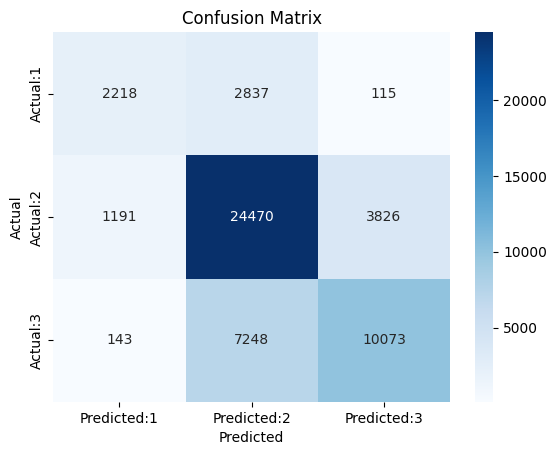

              precision    recall  f1-score   support

           0       0.62      0.43      0.51      5170
           1       0.71      0.83      0.76     29487
           2       0.72      0.58      0.64     17464

    accuracy                           0.71     52121
   macro avg       0.68      0.61      0.64     52121
weighted avg       0.70      0.71      0.70     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.7451
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.7053


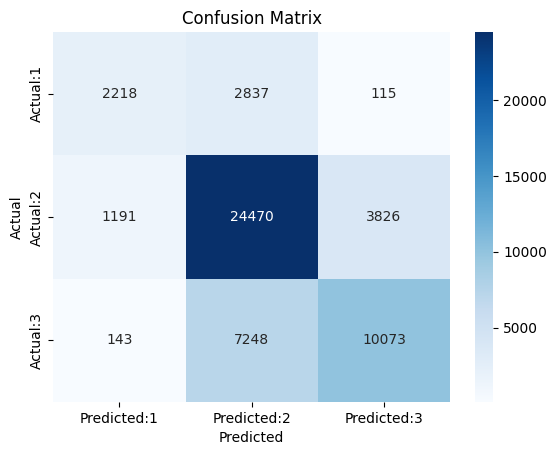

              precision    recall  f1-score   support

           0       0.62      0.43      0.51      5170
           1       0.71      0.83      0.76     29487
           2       0.72      0.58      0.64     17464

    accuracy                           0.71     52121
   macro avg       0.68      0.61      0.64     52121
weighted avg       0.70      0.71      0.70     52121

Model Performance for Training Set after Pruning
F1 Micro-Averaged Score: 0.7451
--------------------------------------
Model Performance for Validation Set after Pruning
F1 Micro-Averaged Score: 0.7053


,Model Name,Train Micro Averaged F1-Score,Val Micro Averaged F1-Score,Time,Parameter
0,DecisionTreeClassifier,0.745064,0.705301,126.83,"{'min_samples_split': 39, 'max_depth': 16, 'class_weight': None}"
1,DecisionTreeClassifier_Pruned,0.745064,0.705301,126.83,"{'min_samples_split': 39, 'max_depth': 16, 'class_weight': None}"


In [25]:
train_and_evaluate_with_tuning_rs_and_pruning(X_train, y_train)

In [ ]:
train_and_evaluate_with_tuning_rs_and_pruning(X_train_under_sample, y_train_under_sample)

In [ ]:
train_and_evaluate_with_tuning_rs_and_pruning(X_train_over_sample, y_train_over_sample)

Best parameters: {'min_samples_split': 20, 'max_depth': 24, 'class_weight': 'balanced'}


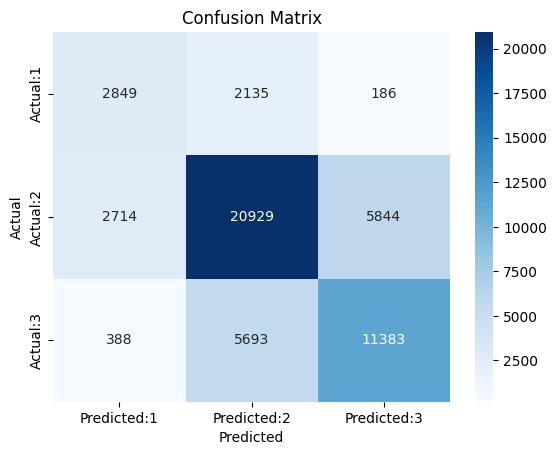

              precision    recall  f1-score   support

           0       0.48      0.55      0.51      5170
           1       0.73      0.71      0.72     29487
           2       0.65      0.65      0.65     17464

    accuracy                           0.67     52121
   macro avg       0.62      0.64      0.63     52121
weighted avg       0.68      0.67      0.68     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.8473
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6746


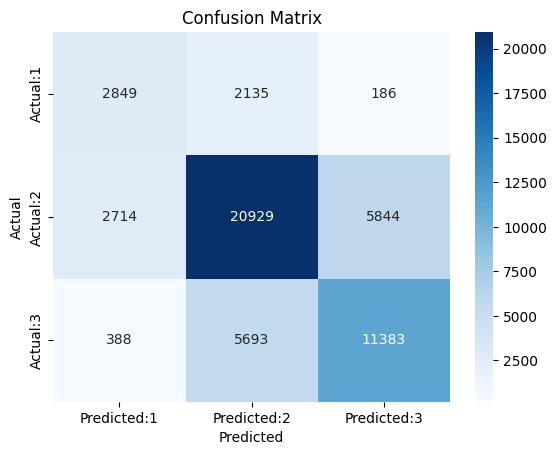

              precision    recall  f1-score   support

           0       0.48      0.55      0.51      5170
           1       0.73      0.71      0.72     29487
           2       0.65      0.65      0.65     17464

    accuracy                           0.67     52121
   macro avg       0.62      0.64      0.63     52121
weighted avg       0.68      0.67      0.68     52121

Model Performance for Training Set after Pruning
F1 Micro-Averaged Score: 0.8473
--------------------------------------
Model Performance for Validation Set after Pruning
F1 Micro-Averaged Score: 0.6746


,Model Name,Train Micro Averaged F1-Score,Val Micro Averaged F1-Score,Time,Parameter
0,DecisionTreeClassifier,0.847296,0.674603,383.88,"{'min_samples_split': 20, 'max_depth': 24, 'class_weight': 'balanced'}"
1,DecisionTreeClassifier_Pruned,0.847296,0.674603,383.88,"{'min_samples_split': 20, 'max_depth': 24, 'class_weight': 'balanced'}"


In [26]:
train_and_evaluate_with_tuning_rs_and_pruning(X_train_smote, y_train_smote)

**We can see that Pruning is not making any difference than no pruning. But, the results is good with the original imbalanced datasets!!**

### Let's see if tuning with other parameters help!

In [27]:
def train_and_evaluate_with_tuning_rs_(X_train, y_train):

    # Create the hyperparameter space
    param_space = {
            "max_depth": np.arange(5, 31),
            "min_samples_split": np.arange(10, 51),
            "min_samples_leaf": np.arange(2, 11),
            "class_weight": ["balanced", None],
            "max_features": [None, "sqrt", "log2"]
        }


    # Create the random search object
    random_search = RandomizedSearchCV(
        DecisionTreeClassifier(random_state=42), param_space, cv=5
    )

    # start time
    start_time = time.time()
    
    # Fit the random search object to the training data
    random_search.fit(X_train, y_train)
    
    # end time
    end_time = time.time()
    
    time_ellapsed = np.round(end_time - start_time, 2)
    
    # Print the best parameters
    print("Best parameters:", random_search.best_params_)

    # Evaluate the best model on the validation data
    y_val_pred = random_search.best_estimator_.predict(X_val)
    
    y_train_pred = random_search.best_estimator_.predict(X_train)

    # Evaluate Train and Validation dataset
    model_train_f1 = evaluate_model(y_train, y_train_pred)
    model_val_f1 = evaluate_model(y_val, y_val_pred, test=True)

    print("Model Performance for Training Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_train_f1))
    print("--------------------------------------")

    print("Model Performance for Validation Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_val_f1))
    
    results = pd.DataFrame([["DecisionTreeClassifier", model_train_f1, model_val_f1, time_ellapsed, random_search.best_params_]], columns=['Model Name', 'Train Micro Averaged F1-Score', 'Val Micro Averaged F1-Score', 'Time', 'Parameter']).sort_values(by=["Val Micro Averaged F1-Score"],ascending=False)
    write_results(results)
    return results

Best parameters: {'min_samples_split': 42, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 8, 'class_weight': None}


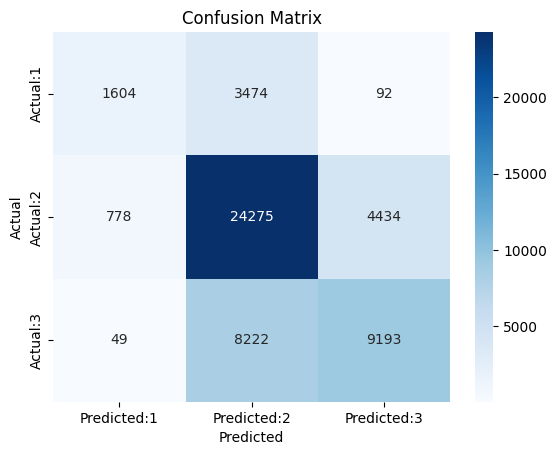

              precision    recall  f1-score   support

           0       0.66      0.31      0.42      5170
           1       0.67      0.82      0.74     29487
           2       0.67      0.53      0.59     17464

    accuracy                           0.67     52121
   macro avg       0.67      0.55      0.58     52121
weighted avg       0.67      0.67      0.66     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.6750
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6729


,Model Name,Train Micro Averaged F1-Score,Val Micro Averaged F1-Score,Time,Parameter
0,DecisionTreeClassifier,0.674986,0.672896,93.59,"{'min_samples_split': 42, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 8, 'class_weight': None}"


In [28]:
train_and_evaluate_with_tuning_rs_(X_train, y_train)

**At least, we see no overfitting above!**

Best parameters: {'min_samples_split': 25, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 24, 'class_weight': None}


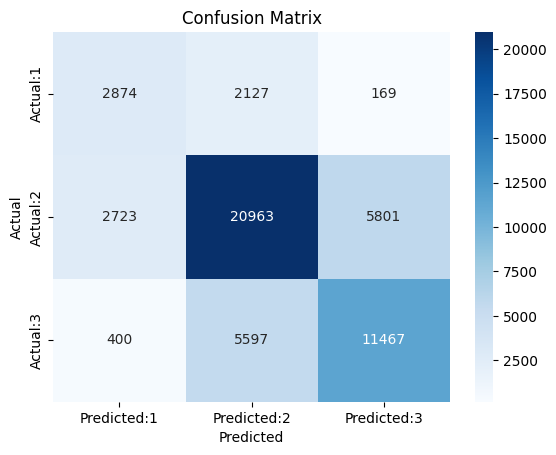

              precision    recall  f1-score   support

           0       0.48      0.56      0.51      5170
           1       0.73      0.71      0.72     29487
           2       0.66      0.66      0.66     17464

    accuracy                           0.68     52121
   macro avg       0.62      0.64      0.63     52121
weighted avg       0.68      0.68      0.68     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.8292
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6773


,Model Name,Train Micro Averaged F1-Score,Val Micro Averaged F1-Score,Time,Parameter
0,DecisionTreeClassifier,0.829171,0.677347,238.86,"{'min_samples_split': 25, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 24, 'class_weight': None}"


In [29]:
train_and_evaluate_with_tuning_rs_(X_train_smote, y_train_smote)

## II. Cost complexity pruning 

In [ ]:
def train_and_evaluate_with_ccp(X_train, y_train):

    # Define the range of values for ccp_alpha
    ccp_alphas = np.arange(0.0, 1.0, 0.01)

    # Create the decision tree classifier with default hyperparameters
    clf = DecisionTreeClassifier(random_state=42)

    # Create the hyperparameter grid
    param_grid = {
        "ccp_alpha": ccp_alphas,
        "max_depth": [5, 10, 15],
        "min_samples_split": [10, 20, 30],
        "min_samples_leaf": [2, 4, 6],
        "class_weight": ["balanced", None],
        "max_features": [None, "sqrt", "log2"]
    }
    
    # start time
    start_time = time.time()

    # Use 5-fold cross-validation to find the optimal hyperparameters
    cv = GridSearchCV(clf, param_grid=param_grid, cv=5)
    cv.fit(X_train, y_train)
        
    # end time
    end_time = time.time()
    
    time_ellapsed = np.round(end_time - start_time, 2)
    
    # Print the best hyperparameters
    print("Best hyperparameters:", cv.best_params_)

    # Evaluate the model with the best hyperparameters on the validation set
    clf_best = cv.best_estimator_
    y_val_pred = clf_best.predict(X_val)

    y_train_pred = clf_best.predict(X_train)
    
    # Evaluate Train and Validation dataset
    model_train_f1 = evaluate_model(y_train, y_train_pred)
    model_val_f1 = evaluate_model(y_val, y_val_pred, test=True)

    print("Model Performance for Training Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_train_f1))
    print("--------------------------------------")

    print("Model Performance for Validation Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_val_f1))
    
    results = pd.DataFrame([["DecisionTreeClassifier_ccp", model_train_f1, model_val_f1, time_ellapsed, random_search.best_params_]], columns=['Model Name', 'Train Micro Averaged F1-Score', 'Val Micro Averaged F1-Score', 'Time', 'Parameter']).sort_values(by=["Val Micro Averaged F1-Score"],ascending=False)
    write_results(results)
    return results

**We might hope for better results with Cross-Complexity Pruning CrossValidation technique, but it take lots of time and computation so we couldn't easily proceed!**

In [ ]:
# train_and_evaluate_with_ccp(X_train, y_train) 


# 4. Modelling with Random Forest Classifier

In [30]:
# Create the random forest object
rfc = RandomForestClassifier(n_estimators = 150, n_jobs=-1, random_state=42)

In [36]:
def train_and_evaluate_rfc_on_all_datasets():

    results_df = pd.DataFrame(columns=['Dataset', 'Model Name', 'Train Micro-Averaged F1-Score', 'Val Micro-Averaged F1-Score', 'Time', 'Parameter'])

    for dataset_name, X_train, y_train in datasets:

        print(f"\n\n Training on dataset: {dataset_name}\n")

        # start time
        start_time = time.time()

        # Fit the random forest object to the training data
        rfc.fit(X_train, y_train)
            
        model_params = {'n_estimators':rfc.get_params()['n_estimators'],'max_depth':rfc.get_params()['max_depth'],
                        'max_features':rfc.get_params()['max_features']}
        
        # end time
        end_time = time.time()

        time_ellapsed = np.round(end_time - start_time, 2)

        # Evaluate the random forest object on the validation data
        y_val_pred = rfc.predict(X_val)

        y_train_pred = rfc.predict(X_train)

        # Evaluate Train and Validation dataset
        model_train_f1 = evaluate_model(y_train, y_train_pred)
        model_val_f1 = evaluate_model(y_val, y_val_pred, test=True)

        print("Model Performance for Training Set")
        print("F1 Micro-Averaged Score: {:.4f}".format(model_train_f1))
        print("--------------------------------------")

        print("Model Performance for Validation Set")
        print("F1 Micro-Averaged Score: {:.4f}".format(model_val_f1))

        results = pd.DataFrame([[dataset_name, "RandomForestClassifier", model_train_f1, model_val_f1, time_ellapsed, model_params]], columns=['Dataset', 'Model Name', 'Train Micro-Averaged F1-Score', 'Val Micro-Averaged F1-Score', 'Time', 'Parameter']).sort_values(by=["Val Micro-Averaged F1-Score"],ascending=False)

        results_df = results_df.append(results, ignore_index=True)

    write_results(results_df, "random_forest_results.csv")

    return results_df

<br>

#### Let's see the performance with Random Forest Classifier on all our datasets.  Hope to see better evaluation results!



 Training on dataset: Original



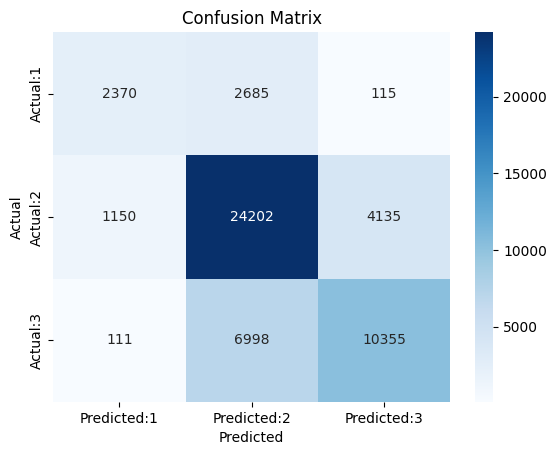

              precision    recall  f1-score   support

           0       0.65      0.46      0.54      5170
           1       0.71      0.82      0.76     29487
           2       0.71      0.59      0.65     17464

    accuracy                           0.71     52121
   macro avg       0.69      0.62      0.65     52121
weighted avg       0.71      0.71      0.70     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.9826
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.7085


 Training on dataset: UnderSampling



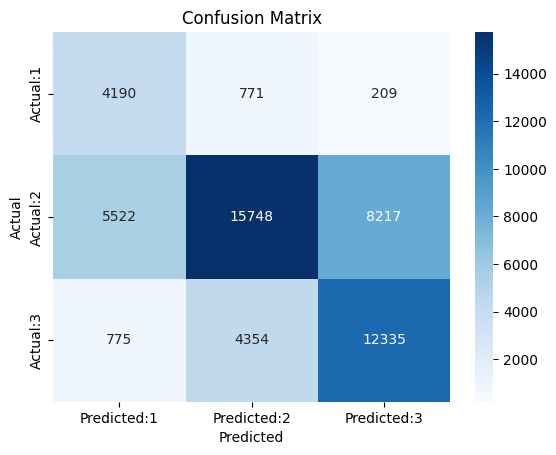

              precision    recall  f1-score   support

           0       0.40      0.81      0.54      5170
           1       0.75      0.53      0.63     29487
           2       0.59      0.71      0.65     17464

    accuracy                           0.62     52121
   macro avg       0.58      0.68      0.60     52121
weighted avg       0.67      0.62      0.62     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.9938
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6192


 Training on dataset: OverSampling



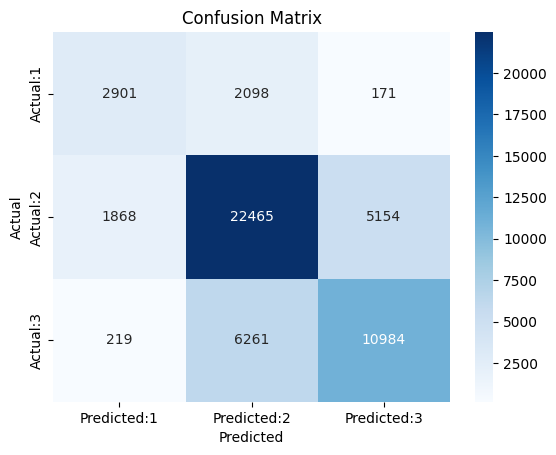

              precision    recall  f1-score   support

           0       0.58      0.56      0.57      5170
           1       0.73      0.76      0.74     29487
           2       0.67      0.63      0.65     17464

    accuracy                           0.70     52121
   macro avg       0.66      0.65      0.66     52121
weighted avg       0.70      0.70      0.70     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.9884
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6974


 Training on dataset: SMOTE



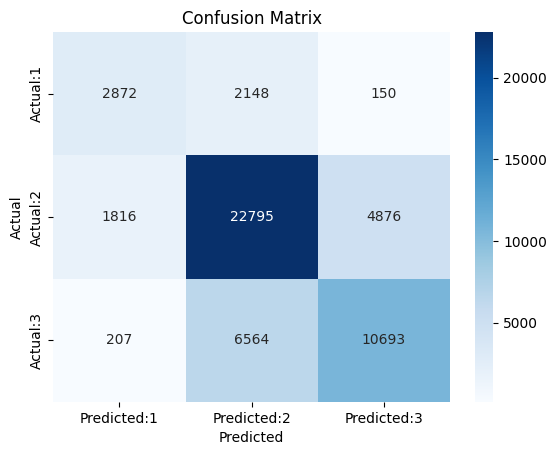

              precision    recall  f1-score   support

           0       0.59      0.56      0.57      5170
           1       0.72      0.77      0.75     29487
           2       0.68      0.61      0.64     17464

    accuracy                           0.70     52121
   macro avg       0.66      0.65      0.65     52121
weighted avg       0.70      0.70      0.70     52121

Model Performance for Training Set
F1 Micro-Averaged Score: 0.9897
--------------------------------------
Model Performance for Validation Set
F1 Micro-Averaged Score: 0.6976


,Dataset,Model Name,Train Micro-Averaged F1-Score,Val Micro-Averaged F1-Score,Time,Parameter
0,Original,RandomForestClassifier,0.982559,0.708486,60.11,"{'n_estimators': 150, 'max_depth': None, 'max_features': 'sqrt'}"
1,UnderSampling,RandomForestClassifier,0.993786,0.619194,13.40,"{'n_estimators': 150, 'max_depth': None, 'max_features': 'sqrt'}"
2,OverSampling,RandomForestClassifier,0.988381,0.697416,119.41,"{'n_estimators': 150, 'max_depth': None, 'max_features': 'sqrt'}"
3,SMOTE,RandomForestClassifier,0.989697,0.697607,132.31,"{'n_estimators': 150, 'max_depth': None, 'max_features': 'sqrt'}"


In [37]:
train_and_evaluate_rfc_on_all_datasets()

**We see the overfitting in our model ! Let's fix them in our Cross Validation step later..** 

**We see that the overfitting incresased but we could expect better performance using Cross Validation techniques!**

> ###  `CONCLUSION`: The models were not able to improve their performance on the test datasets, even after using the undersampling, oversampling, and SMOTE techniques. They generally performed well on the original imbalanced dataset. There was more overfitting in the case of the random forest classifier, which was mostly due to our difficulty performing hyperparameter tuning due to the time it took.

### Let's perform Hyperparameter Tuning with our Random Forest Classifier

In [ ]:
def random_forest_with_tuning(X_train, y_train):

    # Define the hyperparameter space
    param_space = {
        "n_estimators": np.arange(100, 1001, 100),
        "max_depth": [None] + list(np.arange(5, 31, 5)),
        "min_samples_split": np.arange(2, 11),
        "min_samples_leaf": np.arange(1, 6),
        "max_features": [None, "sqrt", "log2"]
    }
    
    # Create the random forest classifier with default hyperparameters
    clf = RandomForestClassifier(random_state=42)

    # Create the random search object
    random_search = RandomizedSearchCV(clf, param_space, cv=5, n_iter=100, n_jobs=-1)
    
    # start time
    start_time = time.time()

    # Fit the random search object to the training data
    random_search.fit(X_train, y_train)

    # end time
    end_time = time.time()
    
    time_ellapsed = np.round(end_time - start_time, 2)
    
    # Print the best hyperparameters
    print("Best hyperparameters:", random_search.best_params_)

    # Evaluate the model with the best hyperparameters on the validation set
    clf_best = random_search.best_estimator_
    y_val_pred = clf_best.predict(X_val)
    val_f1 = f1_score(y_val, y_val_pred, average="micro")
    
    # Evaluate Train and Validation dataset
    model_train_f1 = evaluate_model(y_train, y_train_pred)
    model_val_f1 = evaluate_model(y_val, y_val_pred, test=True)

    print("Model Performance for Training Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_train_f1))
    print("--------------------------------------")

    print("Model Performance for Validation Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_val_f1))

    results = pd.DataFrame([["DecisionTreeClassifier_ccp", model_train_f1, model_val_f1, time_ellapsed, random_search.best_params_]], columns=['Model Name', 'Train Micro Averaged F1-Score', 'Val Micro Averaged F1-Score', 'Time', 'Parameter']).sort_values(by=["Val Micro Averaged F1-Score"],ascending=False)
    write_results(results)
    return results

**Performing Tuning with Random Forest required us lots of time!**

In [ ]:
# random_forest_with_tuning(X_train, y_train)